# I. Data preparation

Loading data from source

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib
import tensorflow.keras.layers as tfl
import os
import pickle
import keras_tuner as kt

In [2]:
from zipfile import ZipFile

# zip_dir = 'data/emotion_data.zip'
# extraction_dir = ""

# with ZipFile(zip_dir, 'r') as zip_object:
#     zip_object.extractall(path=extraction_dir)

# print(f"All files extracted from '{zip_dir}' to '{extraction_dir}'.")

data_dir = pathlib.Path("emotion_data/")

Viewing training data

In [3]:
num_train_images = len(list(data_dir.glob("train/*/*")))
print("Images:", num_train_images)
print("Classes:", list(data_dir.glob("train/*")))

Images: 28709
Classes: [WindowsPath('emotion_data/train/angry'), WindowsPath('emotion_data/train/disgust'), WindowsPath('emotion_data/train/fear'), WindowsPath('emotion_data/train/happy'), WindowsPath('emotion_data/train/neutral'), WindowsPath('emotion_data/train/sad'), WindowsPath('emotion_data/train/surprise')]


Viewing the images

emotion_data\train\angry


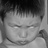

In [4]:
path = list(data_dir.glob("train/*"))[0]
print(str(path))
PIL.Image.open(str(list(path.glob("*"))[0]))

emotion_data\train\disgust


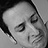

In [5]:
path = list(data_dir.glob("train/*"))[1]
print(str(path))
PIL.Image.open(str(list(path.glob("*"))[0]))

Loading the dataset

In [6]:
train_dir = pathlib.Path("emotion_data/train")

batch_size = 64
# img_height = 180
# img_width = 180
val_split = 0.2

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=val_split,
    subset="both",
    seed=91,
    image_size=(48,48),
    batch_size=batch_size,
    color_mode='grayscale',
    shuffle=True,
    label_mode='categorical'
)
# train_ds = train_ds.shuffle(buffer_size=len(list(train_ds.as_numpy_iterator())))
# val_ds = val_ds.shuffle(buffer_size=len(list(val_ds.as_numpy_iterator())))

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Using 5741 files for validation.


Viewing some batches

In [7]:
b = 3
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    print("Max:", np.max(image_batch.numpy()))
    print("Min:", np.min(image_batch.numpy()))
    print("Labels:", np.unique(labels_batch.numpy()))
    print()
    b-=1
    if b<=0:
        break

(64, 48, 48, 1)
(64, 7)
Max: 255.0
Min: 0.0
Labels: [0. 1.]

(64, 48, 48, 1)
(64, 7)
Max: 255.0
Min: 0.0
Labels: [0. 1.]

(64, 48, 48, 1)
(64, 7)
Max: 255.0
Min: 0.0
Labels: [0. 1.]



## Training preparation

In [8]:
class_names = train_ds.class_names
image_shape = None
labels_shape = None
num_classes = len(class_names)

for image_batch, labels_batch in train_ds:
    image_shape = image_batch.shape[1:]
    labels_shape = labels_batch.numpy().reshape(-1, 1).shape[1:]
    break

print(class_names, image_shape, labels_shape)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'] (48, 48, 1) (1,)


Dataset configuration

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

subset_reduction_factor_train = 0.2
subset_reduction_factor_val = 0.2
num_batches = num_train_images//batch_size

train_subset_size = int(num_batches*(1-val_split)*subset_reduction_factor_train)
val_subset_size = int(num_batches*val_split*subset_reduction_factor_val)

used_train_ds = train_ds.cache().take(train_subset_size).prefetch(buffer_size=AUTOTUNE)
used_val_ds = val_ds.cache().take(val_subset_size).prefetch(buffer_size=AUTOTUNE)

train_subset_size, val_subset_size

(71, 17)

Viewing training and validation data to ensure similar representations

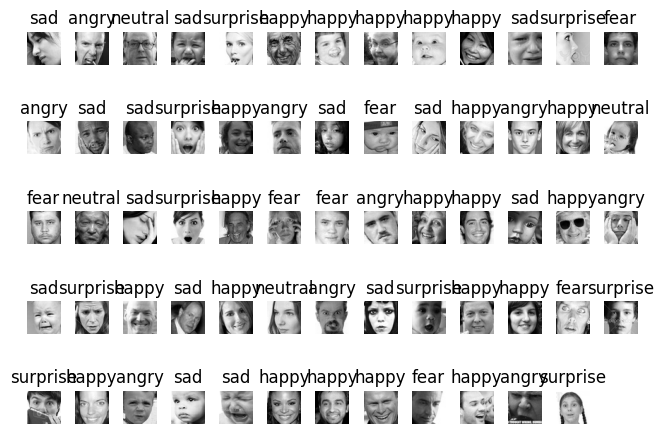

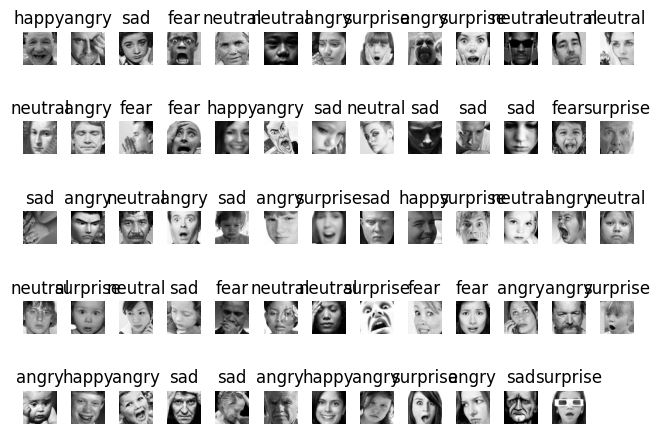

In [10]:
def view_batch(ds, batch_num):
    c = 0
    for image_batch, labels_batch in ds:
        if batch_num != c:
            c+=1
            continue
        # print(image_batch.shape[0], int(np.ceil(image_batch.shape[0]/5)))
        for index, image in enumerate(image_batch):
            # print(labels_batch[index])
            label = np.argmax(labels_batch[index].numpy())
            ax = plt.subplot(5, int(np.ceil(image_batch.shape[0]/5)), index+1)
            ax.imshow(image.numpy().astype("uint8"), cmap="gray")
            ax.axis("off")
            ax.set_title(class_names[int(label)])
        break
    plt.tight_layout()
    plt.show()

def view_batch_shape(ds):
    for i, j in ds:
        print(i.shape, j.shape)
        break

view_batch(used_train_ds, 1)
view_batch(used_val_ds, 1)

# 2. Training

## Utilities

### Save/load utilities

Every time a distinct model is trained and/or used for observations, call `set_save_paths(model_name: str)`. Use the paths `checkpoint_path` and `base_path`, as well as the subroutines below, accordingly.

Information that can be saved and loaded are the training history and the parameters of a model.

By default, models load pretrained weights. Cells containing `model.fit()` can be optionally run once or multiple times by changing the cell format from raw to Python.

To train a fresh model, delete/rename the `training` folder (or its specific subfolders)

In [11]:
base_path:str = None
checkpoint_path:str = None
current_model_name:str = None

In [12]:
def create_path(filepath, isfile=True):
    path = pathlib.Path(filepath)
    if isfile:
        path.parent.mkdir(parents=True, exist_ok=True)
        path.touch(exist_ok=True)
    else:
        path.mkdir(parents=True, exist_ok=True)

def set_save_paths(model_name:tf.keras.Model):
    global checkpoint_path
    global base_path
    global current_model_name
    current_model_name = model_name
    base_path = f"training/{model_name}"
    checkpoint_path = f"{base_path}/parameters.weights.h5"
    print("Save path now belongs to", current_model_name)

def load_parameters(model, custom_model_name=None):
    global checkpoint_path
    global base_path
    global current_model_name

    used_model_name = custom_model_name if custom_model_name != None else current_model_name
    used_checkpoint_path = f"training/{used_model_name}/parameters.weights.h5"

    if not os.path.isfile(used_checkpoint_path):
        print("No parameters found, no parameters loaded from", used_model_name)
        return

    print("Loading parameters of", used_model_name, f"({'Custom' if custom_model_name != None else 'Default'})")

    model.load_weights(used_checkpoint_path, skip_mismatch=True)

def save_object(object, name="history"):
    global checkpoint_path
    global base_path
    global current_model_name

    path = f"{base_path}/{name}"

    create_path(path, isfile=False)

    all_items = os.listdir(path)
    files_only = [os.path.join(path, item) for item in all_items]
    files_only = [item for item in files_only if os.path.isfile(item)]
    
    filepath = f"{path}/{len(files_only)}.pickle"
    create_path(filepath)
    
    print(f"Saving {name} of", current_model_name)
    with open(filepath, 'wb') as f:
        pickle.dump(object.history if name=="history" else object, f)

def load_object(name="history"):
    global checkpoint_path
    global base_path
    global current_model_name
    
    path = f"{base_path}/{name}"

    print(f"Loading {name} of", current_model_name)
    histories = []
    for i in os.listdir(path):
        curpath = os.path.join(path, i)
        if not os.path.isfile(curpath):
            continue
        with open(curpath, 'rb') as f:
            histories.append(pickle.load(f))
    return histories

def plot_object(chosen_attributes, ylim1=0, ylim2=1, name="history"):
    objects = load_object(name)
    for i in chosen_attributes:
        attribute_list = [item for cur_object in objects for item in cur_object[i]]
        plt.plot(np.arange(len(attribute_list)), attribute_list, label=i)
    plt.legend()
    plt.ylim(ylim1, ylim2)
    plt.title(f"{name} of {current_model_name}")
    plt.show()

## Model approaches

### Base architecture
This is the model the following iterations will be built on. It serves as a standard for hyperparameter tuning. It includes:
- Batch normalization
- Depthwise separable convolutions
- Global average pooling
- Residual connections

Save path now belongs to base_model
No parameters found, no parameters loaded from base_model
Epoch 1/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 24s 250ms/step - accuracy: 0.2914 - loss: 1.7741 - val_accuracy: 0.1774 - val_loss: 1.8933
Epoch 2/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.4090 - loss: 1.5370 - val_accuracy: 0.1765 - val_loss: 1.8546
Epoch 3/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.4470 - loss: 1.4536 - val_accuracy: 0.1820 - val_loss: 1.8444
Epoch 4/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 0.4798 - loss: 1.3872 - val_accuracy: 0.1774 - val_loss: 1.8737
Epoch 5/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 0.4856 - loss: 1.3540 - val_accuracy: 0.1829 - val_loss: 1.8923
Epoch 6/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 0.5120 - loss: 1.2961 - val_accuracy: 0.2408 - val_loss: 1.8317
Epoch 7/20
71/71 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - accuracy: 0.5192 - loss: 1.2575 - val_accuracy: 0.1930 - val_loss: 2.0466
Epo

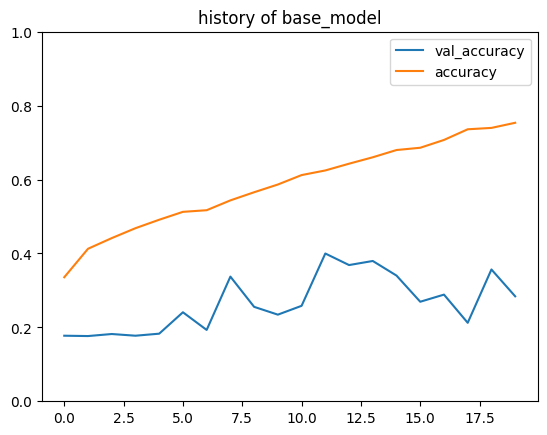

Loading history of base_model


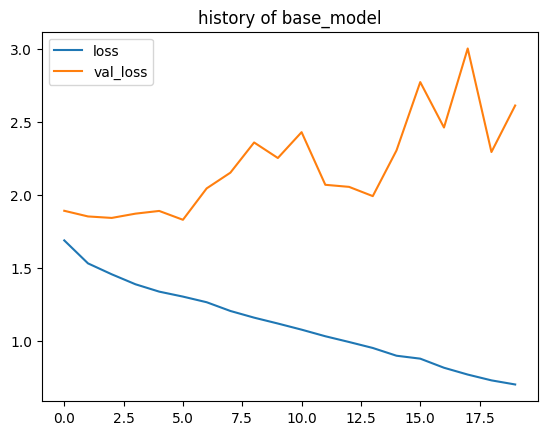

In [ ]:
set_save_paths("base_model")

INPUTS = tfl.Input(shape=image_shape)
L = INPUTS
L = tfl.Rescaling(1/255)(L)
L = tfl.SeparableConv2D(16, 3, padding='same', activation='linear', name="conv1", depthwise_initializer=tf.keras.initializers.GlorotUniform(), pointwise_initializer=tf.keras.initializers.GlorotUniform())(L)
L = tfl.BatchNormalization()(L)
L = tfl.ReLU()(L)
L_ALT = L
L = tfl.MaxPooling2D(2)(L)
L = tfl.SeparableConv2D(32, 3, padding='same', activation='linear', name="conv2", depthwise_initializer=tf.keras.initializers.GlorotUniform(), pointwise_initializer=tf.keras.initializers.GlorotUniform())(L)
L = tfl.BatchNormalization()(L)
L = tfl.ReLU()(L)
L = tfl.MaxPooling2D(2)(L)
L = tfl.SeparableConv2D(64, 3, padding='same', activation='linear', name="conv3", depthwise_initializer=tf.keras.initializers.GlorotUniform(), pointwise_initializer=tf.keras.initializers.GlorotUniform())(L)
L = tfl.BatchNormalization()(L)
L = tfl.ReLU()(L)
L = tfl.MaxPooling2D(2)(L)
L = tfl.SeparableConv2D(128, 3, padding='same', activation='linear', name="conv4", depthwise_initializer=tf.keras.initializers.GlorotUniform(), pointwise_initializer=tf.keras.initializers.GlorotUniform())(L)
L = tfl.BatchNormalization()(L)

L_ALT = tfl.SeparableConv2D(128, 43, padding='valid', activation='linear', name="conv_alt_1", depthwise_initializer=tf.keras.initializers.GlorotUniform(), pointwise_initializer=tf.keras.initializers.GlorotUniform())(L_ALT)
L_ALT = tfl.BatchNormalization()(L_ALT)
L = tfl.Add()([L, L_ALT])

L = tfl.ReLU()(L)
L = tfl.AveragePooling2D(3)(L)
L = tfl.GlobalAveragePooling2D()(L)
L = tfl.Dense(128, activation='relu', name="dense1")(L)
OUTPUTS = tfl.Dense(num_classes, name="dense2")(L)

model = tf.keras.Model(inputs=INPUTS, outputs=OUTPUTS)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

load_parameters(model)
# model.summary()

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',  # Metric to monitor (e.g., validation loss)
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best monitored value
)

history = model.fit(
    used_train_ds,
    validation_data=used_val_ds,
    epochs=20,
    callbacks=[cp_callback, es_callback],
    verbose=1
)

save_object(history)

plot_object(["val_accuracy", "accuracy"])
plot_object(["val_loss", "loss"], None, None)

### Hyperband tuning

In [ ]:
def builder(hp):
    INPUTS = tfl.Input(shape=image_shape)
    L = INPUTS
    L = tfl.Rescaling(1/255)(L)

    # augmentation
    L = tfl.RandomFlip("horizontal", input_shape=image_shape)(L)
    L = tfl.RandomRotation(0.05)(L)
    L = tfl.RandomZoom(height_factor=(-0.1, 0))(L)
    
    hp_dropout_rate = hp.Float('dropout_rate', min_value=0, max_value=0.8)

    L = tfl.SeparableConv2D(16, 3, padding='same', activation='linear', name="conv1", depthwise_initializer=tf.keras.initializers.GlorotUniform(), pointwise_initializer=tf.keras.initializers.GlorotUniform())(L)
    L = tfl.BatchNormalization()(L)
    L = tfl.ReLU()(L)
    L = tfl.SpatialDropout2D(hp_dropout_rate)(L)
    L_ALT = L
    L = tfl.MaxPooling2D(2)(L)

    L = tfl.SeparableConv2D(32, 3, padding='same', activation='linear', name="conv2", depthwise_initializer=tf.keras.initializers.GlorotUniform(), pointwise_initializer=tf.keras.initializers.GlorotUniform())(L)
    L = tfl.BatchNormalization()(L)
    L = tfl.ReLU()(L)
    L = tfl.SpatialDropout2D(hp_dropout_rate)(L)
    L = tfl.MaxPooling2D(2)(L)

    L = tfl.SeparableConv2D(64, 3, padding='same', activation='linear', name="conv3", depthwise_initializer=tf.keras.initializers.GlorotUniform(), pointwise_initializer=tf.keras.initializers.GlorotUniform())(L)
    L = tfl.BatchNormalization()(L)
    L = tfl.ReLU()(L)
    L = tfl.SpatialDropout2D(hp_dropout_rate)(L)
    L = tfl.MaxPooling2D(2)(L)

    L = tfl.SeparableConv2D(128, 3, padding='same', activation='linear', name="conv4", depthwise_initializer=tf.keras.initializers.GlorotUniform(), pointwise_initializer=tf.keras.initializers.GlorotUniform())(L)
    L_ALT = tfl.SeparableConv2D(128, 43, padding='valid', activation='linear', name="conv_alt_1", depthwise_initializer=tf.keras.initializers.GlorotUniform(), pointwise_initializer=tf.keras.initializers.GlorotUniform())(L_ALT)
    L = tfl.Add()([L, L_ALT])
    L = tfl.BatchNormalization()(L)
    L = tfl.ReLU()(L)
    L = tfl.SpatialDropout2D(hp_dropout_rate)(L)
    L = tfl.AveragePooling2D(3)(L)
    
    hp_dense_dropout_rate = hp.Float('dense_dropout_rate', min_value=0, max_value=0.8)
    hp_loss_function = hp.Choice('loss_function', values=["cross_entropy", "focal_loss"])

    L = tfl.GlobalAveragePooling2D()(L)
    L = tfl.Dense(128, activation='relu', name="dense1")(L)
    L = tfl.Dropout(hp_dense_dropout_rate)(L)
    OUTPUTS = tfl.Dense(num_classes, name="dense2", activation="linear" if hp_loss_function=="cross_entropy" else "relu")(L)

    model = tf.keras.Model(inputs=INPUTS, outputs=OUTPUTS)

    hp_label_smoothing = hp.Float('label_smoothing', min_value=0, max_value=1)

    loss_functions = {
        "cross_entropy": tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=hp_label_smoothing),
        "focal_loss": tf.keras.losses.CategoricalFocalCrossentropy(from_logits=True, label_smoothing=hp_label_smoothing)
    }

    model.compile(
        optimizer='adam',
        loss=loss_functions[hp_loss_function],
        metrics=['accuracy']
    )

    return model

# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',  # Metric to monitor (e.g., validation loss)
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best monitored value
)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5
)

tuner = kt.Hyperband(builder,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory="tuning",
                     project_name='hyperband_tuning')

tuner.search(
    used_train_ds,
    validation_data=used_val_ds, 
    epochs=50, 
    callbacks=[es_callback, lr_callback]
)


Reloading Tuner from tuning\hyperband_tuning\tuner0.json


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps["dropout_rate"], best_hps["dense_dropout_rate"], best_hps["loss_function"], best_hps["label_smoothing"]

(0.049829050479595786,
 0.5823360684577414,
 'cross_entropy',
 0.33783031921317896)

In [30]:
model = tuner.get_best_models()[0]
model.evaluate(used_val_ds, return_dict=True)

c:\Users\slotl\Documents\GitHub\ml-with-images\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\slotl\Documents\GitHub\ml-with-images\.venv\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 56 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.4316 - loss: 1.7686


{'accuracy': 0.42003676295280457, 'loss': 1.7729637622833252}

### Final training
We will choose the best hyperparameters and train this for about 100 epochs with a larger subset of data. We will also introduce more residual connections.

In [31]:
AUTOTUNE = tf.data.AUTOTUNE

subset_reduction_factor_train = 0.8
subset_reduction_factor_val = 0.8
num_batches = num_train_images//batch_size

train_subset_size = int(num_batches*(1-val_split)*subset_reduction_factor_train)
val_subset_size = int(num_batches*val_split*subset_reduction_factor_val)

used_train_ds = train_ds.cache().take(train_subset_size).prefetch(buffer_size=AUTOTUNE)
used_val_ds = val_ds.cache().take(val_subset_size).prefetch(buffer_size=AUTOTUNE)

train_subset_size, val_subset_size

(286, 71)

In [39]:
set_save_paths("final")

INPUTS = tfl.Input(shape=image_shape)
L = INPUTS
L = tfl.Rescaling(1/255)(L)

# augmentation
L = tfl.RandomFlip("horizontal", input_shape=image_shape)(L)
L = tfl.RandomRotation(0.05)(L)
L = tfl.RandomZoom(height_factor=(-0.1, 0))(L)

hp_dropout_rate = best_hps["dropout_rate"]

L_ALT = L

L = tfl.SeparableConv2D(16, 3, padding='same', activation='linear', name="conv1", depthwise_initializer=tf.keras.initializers.GlorotUniform(), pointwise_initializer=tf.keras.initializers.GlorotUniform())(L)
L = tfl.BatchNormalization()(L)
L = tfl.ReLU()(L)
L = tfl.SpatialDropout2D(hp_dropout_rate)(L)
L = tfl.MaxPooling2D(2)(L)

L = tfl.SeparableConv2D(32, 3, padding='same', activation='linear', name="conv2", depthwise_initializer=tf.keras.initializers.GlorotUniform(), pointwise_initializer=tf.keras.initializers.GlorotUniform())(L)
L_ALT = tfl.SeparableConv2D(32, 25, padding='valid', activation='linear', name="conv_alt_1", depthwise_initializer=tf.keras.initializers.GlorotUniform(), pointwise_initializer=tf.keras.initializers.GlorotUniform())(L_ALT)
L = tfl.Add()([L, L_ALT])
L = tfl.BatchNormalization()(L)
L = tfl.ReLU()(L)
L = tfl.SpatialDropout2D(hp_dropout_rate)(L)
L = tfl.MaxPooling2D(2)(L)

L_ALT = L

L = tfl.SeparableConv2D(64, 3, padding='same', activation='linear', name="conv3", depthwise_initializer=tf.keras.initializers.GlorotUniform(), pointwise_initializer=tf.keras.initializers.GlorotUniform())(L)
L = tfl.BatchNormalization()(L)
L = tfl.ReLU()(L)
L = tfl.SpatialDropout2D(hp_dropout_rate)(L)
L = tfl.MaxPooling2D(2)(L)

L = tfl.SeparableConv2D(128, 3, padding='same', activation='linear', name="conv4", depthwise_initializer=tf.keras.initializers.GlorotUniform(), pointwise_initializer=tf.keras.initializers.GlorotUniform())(L)
L_ALT = tfl.SeparableConv2D(128, 7, padding='valid', activation='linear', name="conv_alt_2", depthwise_initializer=tf.keras.initializers.GlorotUniform(), pointwise_initializer=tf.keras.initializers.GlorotUniform())(L_ALT)
L = tfl.Add()([L, L_ALT])
L = tfl.BatchNormalization()(L)
L = tfl.ReLU()(L)
L = tfl.SpatialDropout2D(hp_dropout_rate)(L)
L = tfl.AveragePooling2D(3)(L)

hp_dense_dropout_rate = best_hps["dense_dropout_rate"]
hp_loss_function = best_hps["loss_function"]

L = tfl.GlobalAveragePooling2D()(L)
L = tfl.Dense(128, activation='relu', name="dense1")(L)
L = tfl.Dropout(hp_dense_dropout_rate)(L)
OUTPUTS = tfl.Dense(num_classes, name="dense2", activation="linear" if hp_loss_function=="cross_entropy" else "relu")(L)

model = tf.keras.Model(inputs=INPUTS, outputs=OUTPUTS)

hp_label_smoothing = best_hps["label_smoothing"]

loss_functions = {
    "cross_entropy": tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=hp_label_smoothing),
    "focal_loss": tf.keras.losses.CategoricalFocalCrossentropy(from_logits=True, label_smoothing=hp_label_smoothing)
}

model.compile(
    optimizer='adam',
    loss=loss_functions[hp_loss_function],
    metrics=['accuracy']
)

model.summary()

load_parameters(model)

Save path now belongs to final


c:\Users\slotl\Documents\GitHub\ml-with-images\.venv\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_8         │ (None, 48, 48, 1) │          0 │ input_layer_8[0]… │
│ (Rescaling)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_8       │ (None, 48, 48, 1) │          0 │ rescaling_8[0][0] │
│ (RandomFlip)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_8   │ (None, 48, 48, 1) │          0 │ random_flip_8[0]… │
│ (RandomRotation)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom_8       │ (None, 48, 48, 1) │          0 │ random_rotation_… │
│ (RandomZoom)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1               │ (None, 48, 48,    │         41 │ random_zoom_8[0]… │
│ (SeparableConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │         64 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_18 (ReLU)     │ (None, 48, 48,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 48, 48,    │          0 │ re_lu_18[0][0]    │
│ (SpatialDropout2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 24, 24,    │          0 │ spatial_dropout2… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2               │ (None, 24, 24,    │        688 │ max_pooling2d_16… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_alt_1          │ (None, 24, 24,    │        689 │ random_zoom_8[0]… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 24, 24,    │          0 │ conv2[0][0],      │
│                     │ 32)               │            │ conv_alt_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        128 │ add_11[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 24, 24,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout2d_… │ (None, 24, 24,    │          0 │ re_lu_19[0][0]    │
│ (SpatialDropout2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 12, 12,    │          0 │ spatial_dropout2

 Total params: 36,881 (144.07 KB)

 Trainable params: 36,401 (142.19 KB)

 Non-trainable params: 480 (1.88 KB)

No parameters found, no parameters loaded from final


In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=0)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='loss',  # Metric to monitor (e.g., validation loss)
    patience=10,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the best monitored value
)

lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5
)

history = model.fit(
    used_train_ds,
    validation_data=used_val_ds, 
    epochs=100, 
    callbacks=[es_callback, lr_callback, cp_callback]
)

Epoch 1/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 164s 518ms/step - accuracy: 0.2283 - loss: 1.9240 - val_accuracy: 0.2993 - val_loss: 1.8783 - learning_rate: 0.0010
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 67s 235ms/step - accuracy: 0.3111 - loss: 1.8602 - val_accuracy: 0.3316 - val_loss: 1.8344 - learning_rate: 0.0010
Epoch 3/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 64s 223ms/step - accuracy: 0.3286 - loss: 1.8463 - val_accuracy: 0.3305 - val_loss: 1.8209 - learning_rate: 0.0010
Epoch 4/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 63s 221ms/step - accuracy: 0.3383 - loss: 1.8361 - val_accuracy: 0.3726 - val_loss: 1.7965 - learning_rate: 0.0010
Epoch 5/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 66s 232ms/step - accuracy: 0.3551 - loss: 1.8192 - val_accuracy: 0.3625 - val_loss: 1.8069 - learning_rate: 0.0010
Epoch 6/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 65s 225ms/step - accuracy: 0.3686 - loss: 1.8097 - val_accuracy: 0.3607 - val_loss: 1.7980 - learning_rate: 0.0010
Epoch 7/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 63s 220ms/step - accur

In [43]:
save_object(history)

Saving history of final


Loading history of final


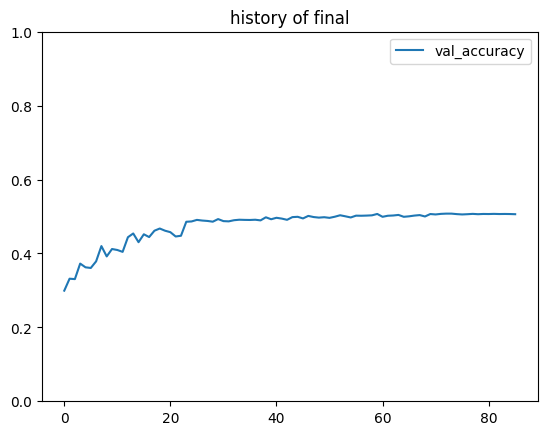

In [44]:
plot_object(["val_accuracy"])

In [42]:
load_object()

Loading history of final
